<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Изучение-моделей-логистической-регрессии-при-учёте-дисбаланса" data-toc-modified-id="Изучение-моделей-логистической-регрессии-при-учёте-дисбаланса-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Изучение моделей логистической регрессии при учёте дисбаланса</a></span></li><li><span><a href="#Изучение-моделей-случайного-леса-при-учёте-дисбаланса" data-toc-modified-id="Изучение-моделей-случайного-леса-при-учёте-дисбаланса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Изучение моделей случайного леса при учёте дисбаланса</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Для решения задачи необходимо построить модель с максимально большим значением *F1*-меры. Заказчик требует довести метрику до 60%. Первым шагом будет получение и изучение данных для обучения моделей. Для обучения модели необходимо кодировать категориальные значения, а также исключить пропуски в данных. Далее разделим кодированный датафрейм на обучающую, валидационную и тестовые выборки. Проверим данные на дисбаланс, исследуем его влияние на поведение модели, уменьшим влияние данного дисбаланса. Так как перед нами стоит задача классификации, то обучим несколько моделей (Логистическая регрессия, Дерево решений и Случайный лес) и выделим лучшую с помощью метрики *F1*. Проверим *F1*-меру на тестовой выборке самостоятельно (предварительно дообучив модель на валидационной выборке, т.к. чем больше данных - тем лучше), затем измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm import tqdm

from pandas.api.types import is_string_dtype

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Для начала отключим предупреждения от sklearn

In [2]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except Exception:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
def describe_dataframe(dataframe):
    display(dataframe.head(10))
    display(dataframe.info())
    display(dataframe.describe(percentiles=[.5]).T)
    print(f"Количество дублированных строк: {dataframe.duplicated().sum()}")

In [5]:
df.query("Tenure.isna()").head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


In [6]:
describe_dataframe(df)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,count,mean,std,min,50%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,5.000500e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,1.569074e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,6.520000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,3.700000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,5.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,9.719854e+04,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,1.001939e+05,199992.48


Количество дублированных строк: 0


<b>Признаки</b>
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата

<b>Целевой признак</b>
Exited — факт ухода клиента

Вывод из исследования данных: в столбце Tenure недостает 9% значений - заменим их нулями. Также имеется 3 столбца с категориальными значениями, которые следует привести к числовому виду. Для этого подойдет метод One-Hot Encoding. Она подходит для решения нашей задачи: работает со всеми моделями. Это критично, так как проверять будем большое количество моделей с разными параметрами.

Заполним нулями недостающие данные в колонке "Tenure"

In [7]:
df["Tenure"].fillna(0, inplace=True)

Поделим датасет на признаки и искомое значение.

In [8]:
target = df['Exited']
features = df.drop(['Exited'], axis=1)

Разделим данные на обучающую, валидационную и тестовую выборки (с учетом дисбаланса).

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.2, random_state=12345, stratify=target)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=.25, random_state=12345, stratify=target_train)

In [10]:
categorical_columns = list(filter(lambda column: is_string_dtype(features_train[column]), features.columns))
numeric_columns = list(filter(lambda column: not is_string_dtype(features_train[column]), features.columns))

Далее кодируем значения категориальных переменных.

In [11]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')
ohe_encoder.fit(features_train[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')

In [12]:
features_train_encoded = pd.DataFrame(
    ohe_encoder.transform(features_train[categorical_columns]).toarray(),
    columns=ohe_encoder.get_feature_names_out(categorical_columns),
    index=features_train.index
)
features_train = pd.concat((features_train[numeric_columns], features_train_encoded), axis=1)
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 5536 to 8193
Columns: 2251 entries, RowNumber to Gender_Male
dtypes: float64(2244), int64(7)
memory usage: 103.1 MB


In [13]:
features_test_encoded = pd.DataFrame(
    ohe_encoder.transform(features_test[categorical_columns]).toarray(),
    columns=ohe_encoder.get_feature_names_out(categorical_columns),
    index=features_test.index
)
features_test = pd.concat(
    (features_test[numeric_columns], features_test_encoded),
    axis=1
)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9375 to 1674
Columns: 2251 entries, RowNumber to Gender_Male
dtypes: float64(2244), int64(7)
memory usage: 34.4 MB


C:\Users\APMuravev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
features_valid_encoded = pd.DataFrame(
    ohe_encoder.transform(features_valid[categorical_columns]).toarray(),
    columns=ohe_encoder.get_feature_names_out(categorical_columns),
    index=features_valid.index
)
features_valid = pd.concat(
    (features_valid[numeric_columns], features_valid_encoded),
    axis=1
)
features_valid.info()

C:\Users\APMuravev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 7837 to 1729
Columns: 2251 entries, RowNumber to Gender_Male
dtypes: float64(2244), int64(7)
memory usage: 34.4 MB


In [15]:
target_test.index = features_test['RowNumber']
features_test.index = features_test['RowNumber']
features_test.drop(['RowNumber'], axis=1, inplace=True)

In [16]:
target_train.index = features_train['RowNumber']
features_train.index = features_train['RowNumber']
features_train.drop(['RowNumber'], axis=1, inplace=True)

In [17]:
target_valid.index = features_valid['RowNumber']
features_valid.index = features_valid['RowNumber']
features_valid.drop(['RowNumber'], axis=1, inplace=True)

Данные готовы к исследованию.

## Исследование задачи

Проверим таргет на дисбаланс. Посчитаем отношение нулей и единиц.

In [18]:
accuracy_score(target_test, pd.Series(0, index=target_test.index))

0.7965

<Axes: >

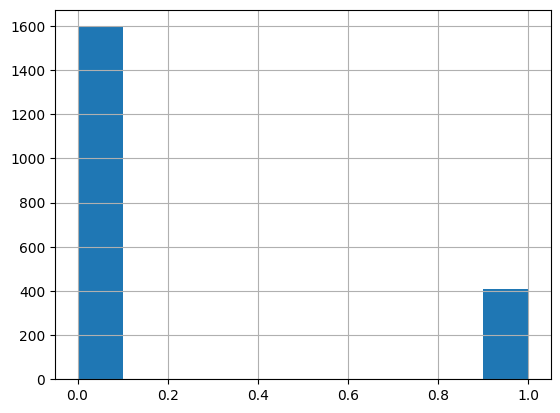

In [19]:
target_test.hist()

Нулей 80% от общего количества значений в таргете, наблюдается явный дисбаланс классов. В других выборках дисбаланс аналогичен.

Для того чтобы у всех признаков был единый масштаб, стандартизируем их с помощью отдельной структуры для стандартизации данных sklearn.preprocessing.StandardScaler.

In [20]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(
    scaler.transform(features_train),
    columns=features_train.columns,
    index=features_train.index)

features_test = pd.DataFrame(
    scaler.transform(features_test),
    columns=features_test.columns,
    index=features_test.index)

features_valid = pd.DataFrame(
    scaler.transform(features_valid),
    columns=features_valid.columns,
    index=features_valid.index)

describe_dataframe(features_train)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Surname_Abbott,...,Surname_Zotov,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,,,,,,,,,,
5537,1.454988,-0.143332,0.577533,-1.456283,-1.220573,0.797767,0.652576,0.967527,1.029613,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,1.734363,0.915552
8531,0.166309,1.632702,-0.564119,-0.813711,0.435807,-0.916018,0.652576,-1.033563,0.237986,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,-0.576580,-1.092237
1763,1.730513,1.116413,-0.468981,-1.134997,1.245822,-0.916018,0.652576,0.967527,-0.686104,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,-0.576580,-1.092237
9091,1.706152,1.643028,0.006707,0.150148,-1.220573,-0.916018,0.652576,-1.033563,-0.391097,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,-0.576580,-1.092237
8778,0.440831,-0.484083,-1.420358,-1.134997,1.421989,0.797767,0.652576,-1.033563,-1.361559,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,1.734363,0.915552
6145,-1.031978,0.445237,0.672671,-0.492424,1.206938,-0.916018,0.652576,-1.033563,1.399264,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,1.734363,-1.092237
5498,0.264738,1.281625,-0.278706,1.114006,0.653989,-0.916018,-1.532388,-1.033563,0.028082,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,1.734363,-1.092237
8657,1.391810,0.104487,-0.754394,-1.134997,0.132478,-0.916018,0.652576,0.967527,0.652887,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,1.734363,0.915552
8834,0.967436,-0.577015,1.053222,0.792720,0.080479,-0.916018,0.652576,0.967527,1.453685,-0.022366,...,-0.012911,-0.012911,-0.022366,-0.012911,-0.012911,-0.01826,-0.012911,-0.572988,-0.576580,0.915552


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 5537 to 8194
Columns: 2250 entries, CustomerId to Gender_Male
dtypes: float64(2250)
memory usage: 103.0 MB


None

,count,mean,std,min,50%,max
CustomerId,6000.0,-9.061788e-15,1.000083,-1.750860,-0.002715,1.730513
CreditScore,6000.0,2.925068e-16,1.000083,-3.096505,0.011555,2.066384
Age,6000.0,2.581639e-16,1.000083,-1.991184,-0.183568,5.049004
Tenure,6000.0,2.723747e-17,1.000083,-1.456283,-0.171138,1.756578
Balance,6000.0,1.207923e-16,1.000083,-1.220573,0.334671,2.794064
...,...,...,...,...,...,...
Surname_Zuyev,6000.0,-1.184238e-18,1.000083,-0.018260,-0.018260,54.763126
Surname_Zuyeva,6000.0,3.552714e-18,1.000083,-0.012911,-0.012911,77.453212
Geography_Germany,6000.0,5.684342e-17,1.000083,-0.572988,-0.572988,1.745237
Geography_Spain,6000.0,-3.907985e-17,1.000083,-0.576580,-0.576580,1.734363


Количество дублированных строк: 0


Попробуем обучить модели без учета дисбаланса и просмотрим чему будет равна метрика F1. Так как перед нами стоит задача классификации, то будем использовать 3 модели: Логистическую регрессию, Дерево решений и Случайный лес.

Для построения roc кривой пропишем специальную функцию.

In [21]:
def roc_graph(tv, pv):
    fpr, tpr, thresholds = roc_curve(tv, pv)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

Обучим модель логистической регрессии. (LR)

'F1: 0.26751592356687903'

array([[1456,  137],
       [ 323,   84]], dtype=int64)

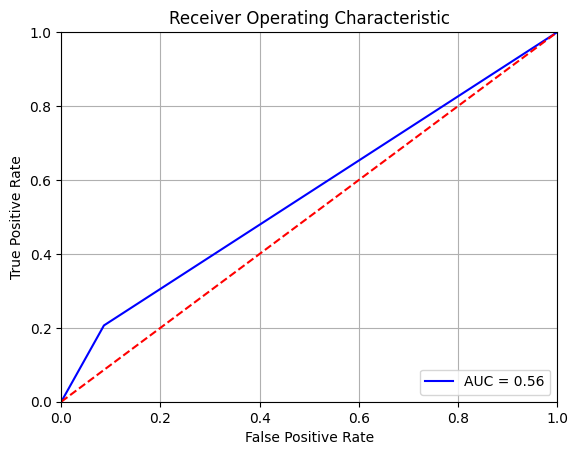

In [22]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
display(f"F1: {f1_score(target_valid, predicted_valid)}")
display(confusion_matrix(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, predicted_valid)

У модели крайне низкая полнота, поэтому метрика F1 мала, такая модель не соответствует требуемой

Обучим модель дерева решений. (DT)

Метрика F1 наилучшей DT модели на дисбалансированной валидационной выборке: 0.5792682926829269 Максимальная глубина: 6


array([[1456,  137],
       [ 323,   84]], dtype=int64)

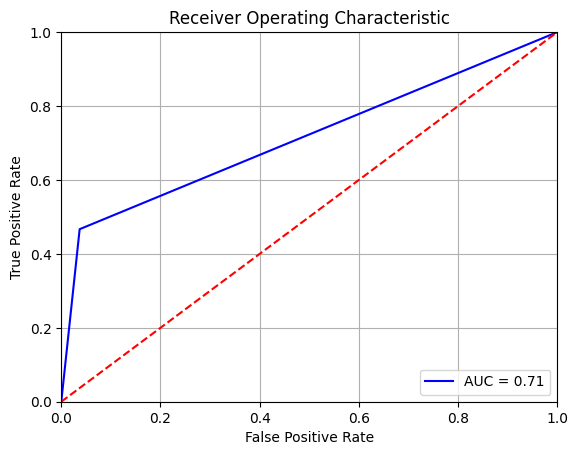

In [23]:
best_dt_model = None
best_result = 0
best_depth = 0
best_predicted_valid = None
for depth in range (1, 16):
    dt_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt_model.fit(features_train, target_train)
    predictions_valid = dt_model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_dt_model = dt_model
        best_result = result
        best_depth = depth
        best_predicted_valid = predictions_valid

print("Метрика F1 наилучшей DT модели на дисбалансированной валидационной выборке:", best_result, "Максимальная глубина:", best_depth)
display(confusion_matrix(target_valid, predicted_valid))

if best_dt_model:
    probabilities_test = best_dt_model.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_graph(target_valid, best_predicted_valid)

Сразу же получаем результат, близкий к требуемому. Неплохо, но все равно мало.

Обучим модель случайного леса. (RF)

100%|██████████| 14/14 [02:22<00:00, 10.15s/it]

Метрика F1 наилучшей модели на дисбалансированной валидационной выборке: 0.04796163069544364 Количество деревьев: 20 Максимальная глубина: 13


array([[1456,  137],
       [ 323,   84]], dtype=int64)

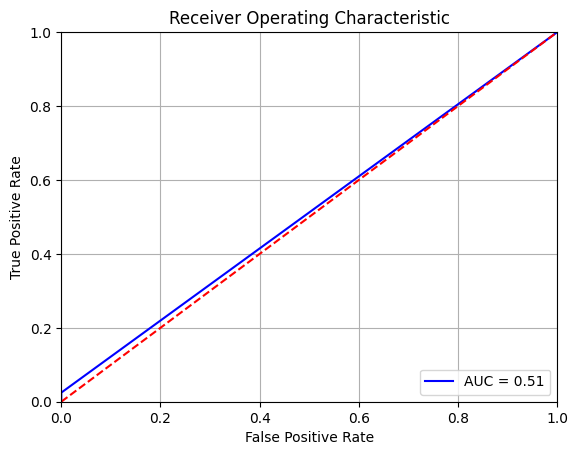

In [24]:
best_rf_model = None
best_result = 0
best_est = 0
best_depth = 0
best_predicted_valid = None
for n_estimators in tqdm(range(10, 141, 10)):
    for depth in range (1, 16):
        rf_model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators)
        rf_model.fit(features_train, target_train)
        predictions_valid = rf_model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_rf_model = rf_model
            best_result = result
            best_est = n_estimators
            best_depth = depth
            best_predicted_valid = predictions_valid

print("Метрика F1 наилучшей модели на дисбалансированной валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)
display(confusion_matrix(target_valid, predicted_valid))
if best_rf_model:
    probabilities_test = best_rf_model.predict_proba(features_valid)
    probabilities_one_test = probabilities_test[:, 1]
    roc_graph(target_valid, best_predicted_valid)

Метрика F1 получилась мовсем плохой, т.е неточные модели повлияли на хорошие.

Выводы: Дисбаланс и мультиколлинеарность - это проблема для линейных моделей, по типу логистической (LR) и линейной регрессий. Скорее всего в данном датасете более сложные, нелинейные связи между признаками и таргетом. "Деревянные" модели (RF, DT) устойчивы к мультиколлинеарности, данные модели гораздо лучше показывают себя при существующем дисбалансе классов. На других данных LR могла оказаться лучше, например потому что RF не может экстраполировать.

## Борьба с дисбалансом

Для борьбы с дисбалансом есть несколько способов: взвешивание класса, увеличение выборки, уменьшение выборки и изменение порога принятия решения.

Определим функции для увеличения и уменьшения выборки.

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

Найдем новые выборки исходя из того, что баланс классов = 0.8, т.е. нули в таргете относятся к единицам как 4/1 => мы либо уменьшаем количество нулей в 4 раза, либо увеличиваем количество единиц в 4 раза.

In [27]:
features = df.drop(['Exited'], axis=1)
target = df['Exited']

features = pd.get_dummies(features, drop_first=True)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.2, random_state=12345, stratify=target)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=.25, random_state=12345, stratify=target_train)

In [28]:
features_downsampled, target_downsampled = downsample(pd.DataFrame(features_train), target_train, 0.25)
display(features_downsampled.shape, target_downsampled.shape)

(2417, 2944)

(2417,)

In [29]:
features_upsampled, target_upsampled = upsample(pd.DataFrame(features_train), target_train, 4)
display(features_upsampled.shape, target_upsampled.shape)

(9669, 2944)

(9669,)

### Изучение моделей логистической регрессии при учёте дисбаланса

Протестируем модель логистической регрессии на уменьшенной выборке:

'F1: 0.36690186016677356'

array([[727, 866],
       [121, 286]], dtype=int64)

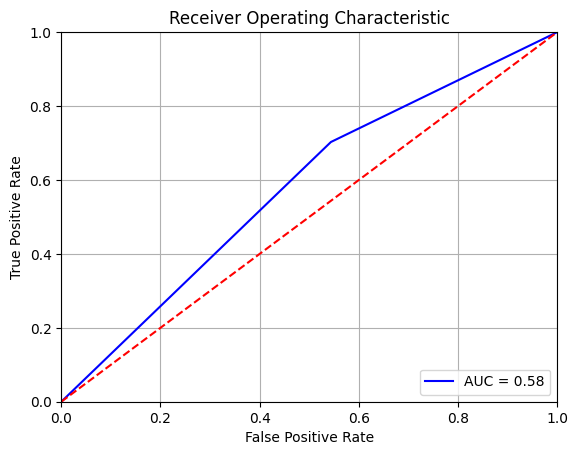

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
display(f"F1: {f1_score(target_valid, predicted_valid)}")
display(confusion_matrix(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, predicted_valid)

Протестируем модель логистической регрессии на увеличенной выборке:

'F1: 0.36525047558655677'

array([[711, 882],
       [119, 288]], dtype=int64)

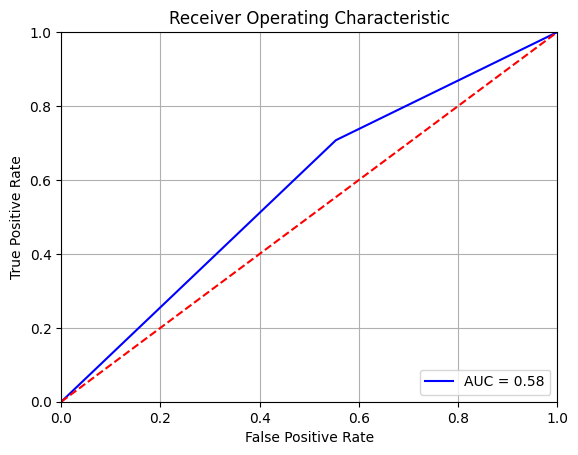

In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
display(f"F1: {f1_score(target_valid, predicted_valid)}")
display(confusion_matrix(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, predicted_valid)

Обе модели показывают одинаково низкий результат: около 0.37.

Применим встроенное взвешивание классов.

'F1: 0.5046570702794242'

array([[1117,  476],
       [ 109,  298]], dtype=int64)

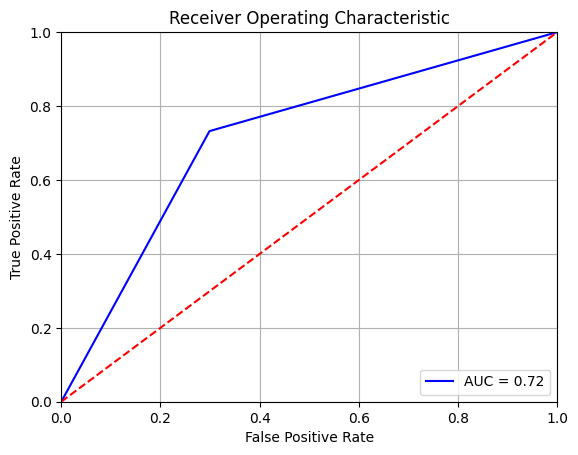

In [32]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
display(f"F1: {f1_score(target_valid, predicted_valid)}")
display(confusion_matrix(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, predicted_valid)

Качество модели заметно повысилось, но качество не дотягивает до требуемого.


Протестируем изменения порога принятия решения.

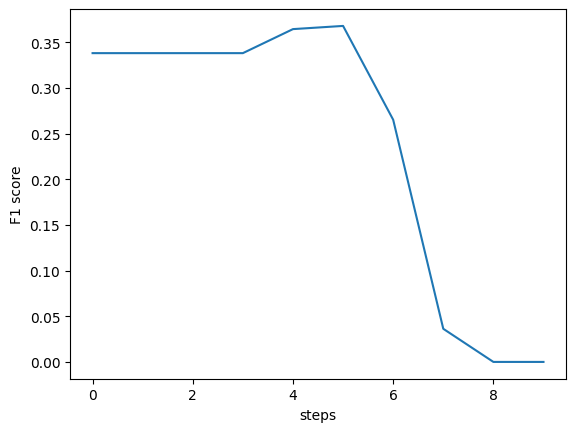

In [33]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
threshold_target_results = []
for threshold in np.arange(0, 0.4, 0.04):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    threshold_target_results.append(score)
plt.plot(threshold_target_results)
plt.ylabel('F1 score')
plt.xlabel('steps')
plt.show()

Изменение порога также не даёт видимого эффекта. В лучшем случае качество модели сопоставимо с моделью, обученной на уменьшенном/увеличенном датасете.

### Изучение моделей случайного леса при учёте дисбаланса

100%|██████████| 14/14 [03:00<00:00, 12.87s/it]

Метрика F1 наилучшей модели на сбалансированной валидационной выборке: 0.5991649269311066 Количество деревьев: 50 Максимальная глубина: 14


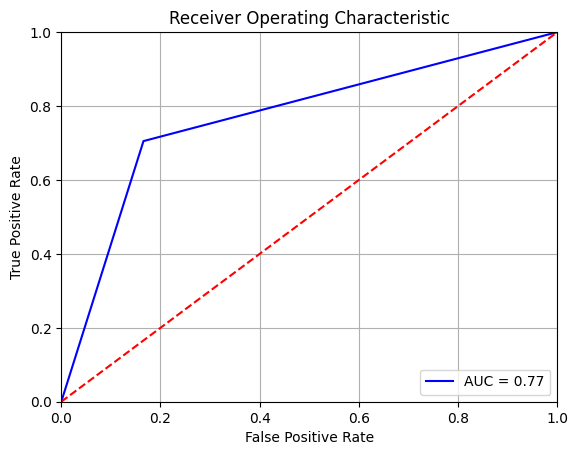

In [34]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_predicted_valid = None
for n_estimators in tqdm(range(10, 141, 10)):
    for depth in range (1, 16):
        forest_model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, class_weight='balanced')
        forest_model.fit(features_train, target_train)
        predictions_valid = forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_fm_weighted = forest_model
            best_result = result
            best_est = n_estimators
            best_depth = depth
            best_predicted_valid = predictions_valid

print("Метрика F1 наилучшей модели на сбалансированной валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

probabilities_test = best_fm_weighted.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, best_predicted_valid)

100%|██████████| 14/14 [01:27<00:00,  6.27s/it]


Метрика F1 наилучшей модели на уменьшенной валидационной выборке: 0.5754884547069272 Количество деревьев: 120 Максимальная глубина: 14


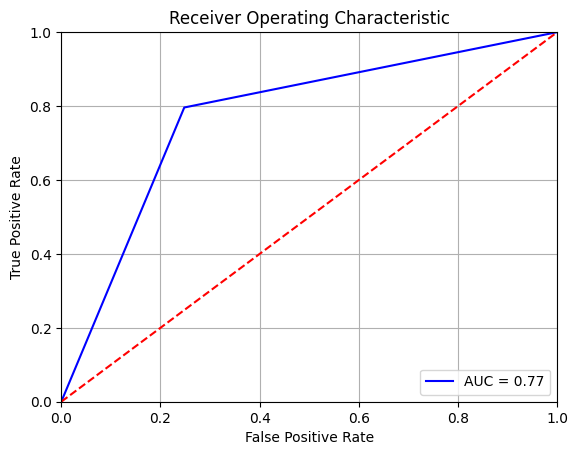

In [35]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_predicted_valid = None
for n_estimators in tqdm(range(10, 141, 10)):
    for depth in range (1, 16):
        forest_model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators)
        forest_model.fit(features_downsampled, target_downsampled)
        predictions_valid = forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_fm_downsampled = forest_model
            best_result = result
            best_est = n_estimators
            best_depth = depth
            best_predicted_valid = predictions_valid

print("Метрика F1 наилучшей модели на уменьшенной валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

probabilities_test = best_fm_downsampled.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, best_predicted_valid)

100%|██████████| 14/14 [04:21<00:00, 18.66s/it]


Метрика F1 наилучшей модели на увеличенной валидационной выборке: 0.5746061167747916 Количество деревьев: 80 Максимальная глубина: 14


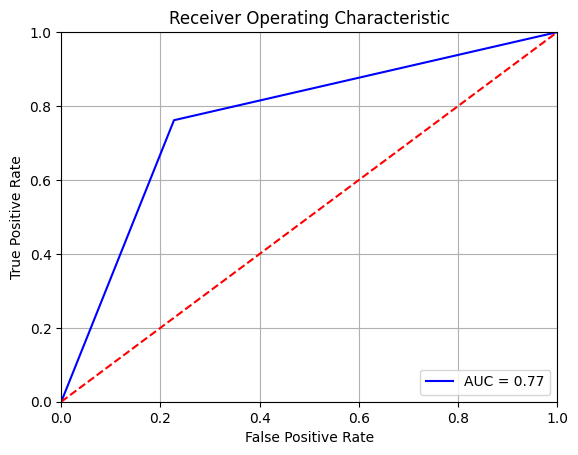

In [36]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_predicted_valid = None
for n_estimators in tqdm(range(10, 141, 10)):
    for depth in range (1, 16):
        forest_model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators)
        forest_model.fit(features_upsampled, target_upsampled)
        predictions_valid = forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_fm_upsampled = forest_model
            best_result = result
            best_est = n_estimators
            best_depth = depth
            best_predicted_valid = predictions_valid

print("Метрика F1 наилучшей модели на увеличенной валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

probabilities_test = best_fm_upsampled.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_valid, best_predicted_valid)

Выводы: Наилучшим образом себя показали модели случайного леса, все три получившиеся метрики F1 близки к требуемым. Выводы исследования подтвердились, встроенная функция взвешивания классов позволяет получить наилучшую модель, точность метрики F1 которой соответствует требованиям.

## Тестирование модели

Протестируем модель на тестовой выборке

In [37]:
predictions_test = best_fm_weighted.predict(features_test)
result = f1_score(target_test, predictions_test)
display(result)

0.5970772442588727

Задача решена.

Теперь попробуем дообучить её с использованием валидационных данных (они нам больше не понадобятся). После чего заново определим наилучшие гиперпараметры модели, это может повысить значение метрики F1.

In [38]:
best_forest_model = None
best_result = 0
best_est = 0
best_depth = 0
best_predicted_valid = None
for n_estimators in tqdm(range(10, 141, 10)):
    for depth in range (1, 16):
        forest_model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, class_weight='balanced')
        forest_model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
        predictions_test = forest_model.predict(features_test)
        result = f1_score(target_test, predictions_test)
        if result > best_result:
            best_forest_model = forest_model
            best_result = result
            best_est = n_estimators
            best_depth = depth
            best_predicted_valid = predictions_test

print("Метрика F1 наилучшей модели на тестовой выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

100%|██████████| 14/14 [03:51<00:00, 16.54s/it]

Метрика F1 наилучшей модели на тестовой выборке: 0.602510460251046 Количество деревьев: 140 Максимальная глубина: 12


Дообучив модель, была получена метрика f1 = 0.6.

Далее исследуем метрику AUC-ROC

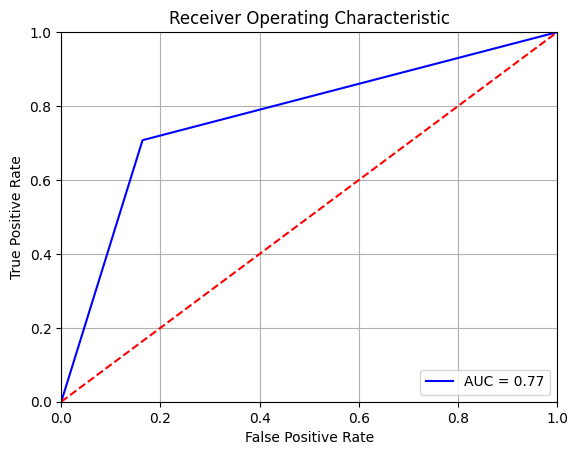

In [39]:
probabilities_test = best_forest_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_graph(target_test, best_predicted_valid)

Выводы: В данной работе необходимо было построить модель для задачи классификации, которая спрогнозирует, уйдёт клиент из банка в ближайшее время или нет. Для решения задачи необходимо построить модель с максимально большим значением метрики F1. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Была проведена работа по изучению и разделению данных на выборки для обучения и тестирования моделей, перед этим было проведено кодирование категориальных значений, а также исключены пропуски в данных. Был исследован и устранен дисбаланс данных, далее для каждой модели был проведён подбор оптимальных гиперпараметров, после чего была выявлена оптимальная модель с наибольшим значением метрики F1 = 0.6, что выше требуемая 0.59. Данная модель была проверена на тестовых данных, а также была оценена AUC-ROC метрика, она равна 0.77, что является хорошим показателем при метрике F1=0.6, из чего следует, что модель получилась точная. Две лучших набора гиперпараметров: 1) F1 = 0.605 Количество деревьев: 110 Максимальная глубина: 15 2) F1 = 0.6 Количество деревьев: 140 Максимальная глубина: 11. Предпочтительнее выбрать более легковесную модель, она будет быстрее работать.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*